In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy
from keras.layers.convolutional import Conv1D, MaxPooling1D

# Carga de datos

In [3]:
df = pd.read_csv('../data/PERU_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1995-03-01 to 2022-09-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  331 non-null    float64
 1   PN38705PM  331 non-null    float64
 2   PN02020AM  331 non-null    float64
 3   PN02028AM  331 non-null    float64
 4   PD37972BM  331 non-null    float64
 5   PD37974BM  331 non-null    float64
 6   PD37976BM  331 non-null    float64
 7   Class      331 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 23.3 KB


In [5]:
df.describe()

,PN02312FM,PN38705PM,PN02020AM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.007333,0.003076,0.002147,0.002553,0.005870,0.003140,0.004260,0.117825
std,0.009396,0.002156,0.006948,0.006737,0.007171,0.014114,0.008570,0.322889
min,-0.023065,-0.000396,-0.019100,-0.024735,-0.014352,-0.044618,-0.021834,0.000000
25%,0.001821,0.001677,-0.001747,-0.001154,0.001794,-0.004155,-0.000763,0.000000
50%,0.007930,0.002582,0.002351,0.002729,0.006407,0.003949,0.004378,0.000000
75%,0.011984,0.003378,0.006768,0.006601,0.009957,0.010879,0.009684,0.000000
max,0.042614,0.009731,0.017409,0.027911,0.025603,0.036833,0.026307,1.000000


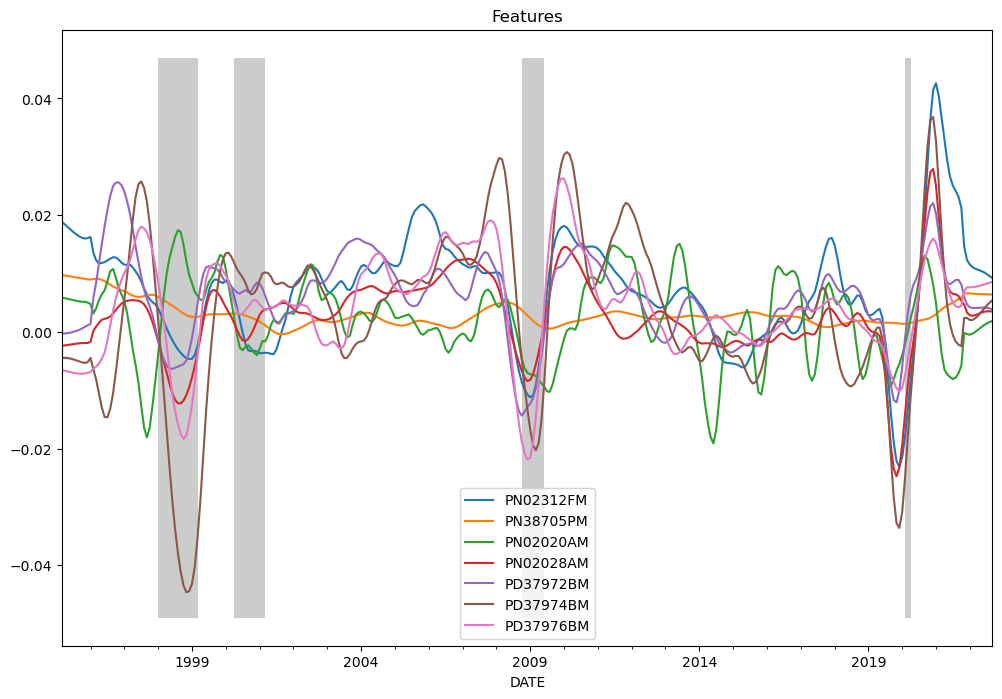

In [6]:
graficarTodo(df,'Features')

# Mostrar Imbalance de clases

In [7]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 331
    Positive: 39 (11.78% of total)



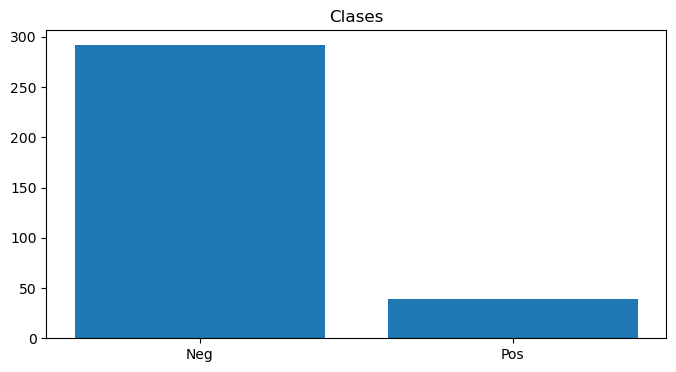

In [8]:
graficarClases(df['Class'])

In [9]:
initial_bias = np.log([pos/neg])

In [10]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 4.24


# Dividir Datos

In [11]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.3)

# Normalizar

In [12]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

## Modelo

In [13]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_cnn(n_steps_in: int, n_features: int, conv1_kernels: int,
              conv1_kernel_size: int, conv1_dropout : float, conv2_kernels: int,
              conv2_kernel_size: int, conv2_dropout : float, dense_nodes: int, 
              dense_layers : int, dense_dropout : float, learning_rate: float, 
              conv_activation = None, dense_activation = None,
              metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = Constant(output_bias)
    model = Sequential()
    # Conv 1
    model.add(Conv1D(
        filters=conv1_kernels,
        kernel_size=conv1_kernel_size,
        activation=conv_activation, 
        padding = 'same',
        input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=conv1_kernel_size, padding='same'))
    model.add(Dropout(conv1_dropout))
    # Conv 2
    model.add(Conv1D(
        filters=conv2_kernels,
        kernel_size=conv2_kernel_size,
        activation=conv_activation, 
        padding = 'same'))
    model.add(MaxPooling1D(pool_size=conv2_kernel_size, padding='same'))
    model.add(Dropout(conv2_dropout))
    # Dense
    model.add(Flatten())
    for i in range(dense_layers):
        model.add(Dense(dense_nodes, activation=dense_activation))
    model.add(Dropout(dense_dropout))
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=BinaryCrossentropy(), metrics=metrics)
    return model

2022-12-29 11:45:11.844146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 11:45:12.671908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10088 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-12-29 11:45:12.672375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9910 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6


## Optimizador

In [14]:
class CNNHyperModel(HyperModel):

    def __init__(self, n_features_in,n_steps_out, output_bias = None, class_weight= None, name = None, tunable = True):
        super().__init__(name=name, tunable=tunable)
        self.n_features = n_features_in
        self.n_steps_out = n_steps_out
        self.output_bias = output_bias
        self.class_weight = class_weight

    def build(self, hp):
        # Parametrizamos nro de capas, nro de nodos y ratio de aprendizaje
        hp_time_steps = hp.Int('steps_in',4,24,step=1)
        hp_conv1_kernels = hp.Int('conv1_kernels',32,356,step=16)
        hp_conv1_kernel_size = hp.Int('conv1_kernel_size',2,5,step=1)
        hp_conv1_dropout = hp.Float('conv1_dropout',0.1,0.5,step=0.1)
        hp_conv2_kernels = hp.Int('conv2_kernels',32,356,step=16)
        hp_conv2_kernel_size = hp.Int('conv2_kernel_size',2,5,step=1)
        hp_conv2_dropout = hp.Float('conv2_dropout',0.1,0.5,step=0.1)
        hp_dense_nodes = hp.Int('dense_nodes',32,356,step=16)
        hp_dense_layers = hp.Int('dense_layers',1,5,step=1)
        hp_dense_dropout = hp.Float('dense_dropout',0.1,0.5,step=0.1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
        hp_conv_activation = hp.Choice('conv_activation', values=['relu','tanh'])
        hp_dense_activation = hp.Choice('dense_activation', values=['relu','tanh'])

        return build_cnn(
            n_steps_in = hp_time_steps,
            n_features = self.n_features,
            conv1_kernels = hp_conv1_kernels,
            conv1_kernel_size = hp_conv1_kernel_size,
            conv1_dropout = hp_conv1_dropout,
            conv2_kernels = hp_conv2_kernels,
            conv2_kernel_size = hp_conv2_kernel_size,
            conv2_dropout = hp_conv2_dropout,
            dense_nodes = hp_dense_nodes,
            dense_layers = hp_dense_layers,
            dense_dropout = hp_dense_dropout,
            learning_rate = hp_learning_rate,
            conv_activation = hp_conv_activation,
            dense_activation = hp_dense_activation
        )

    def fit(self, hp, model,x,y,**kwargs):
        x_s,y_s = shift_data(x, y, hp.get('steps_in'), self.n_steps_out)
        #mini_batch = 32
        batch_learning = len(x_s)
        return model.fit(x = x_s, y = y_s, batch_size = batch_learning, class_weight=self.class_weight, **kwargs)

In [15]:
n_steps_out = [1,6,12,24]
n_features = len(features)
ajuste_path = os.path.normpath('G:/')
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
objective = kt.Objective('val_prc',direction='max')
max_epochs = 30
n_epochs = 50

In [16]:
output_path = 'ajustes/'
output_path_model = 'modelos/'
name_prj = 'CNN_USA_'
N = 20


In [17]:
def optimizar_y_entrenar(name_prj, n_steps_out):
    name_prj = name_prj + str(n_steps_out) +'_'+fecha_hora
    name_model_tun = output_path+name_prj+'.h5'
    # Condicion de parada: 10 epocas despues del menor val_loss
    es = EarlyStopping(
        monitor='val_prc', 
        verbose=0,
        patience=10,
        mode='max',
        restore_best_weights=True)
    
    # --------------------- Optimizacion --------------------------------------
    cnn_hypermodel = CNNHyperModel(n_features, n_steps_out, class_weight = class_weight) # output_bias=initial_bias

    cnn_tuner = kt.Hyperband(
        cnn_hypermodel,
        objective = objective,
        max_epochs = max_epochs,
        #directory = ajuste_path,
        project_name = name_prj,
        overwrite=True)

    print("Optimizando...")
    cnn_tuner.search(x = df_x_train, y = df_y_train, validation_split = 0.5, epochs = n_epochs
        , verbose = 2, shuffle = False, callbacks = [es])

    # guardar parametros de mejor modelo
    best_cnn_hps = cnn_tuner.get_best_hyperparameters(num_trials = 1)[0]
    print_hp(output_path+name_prj+'.txt',cnn_tuner)

    cnn_model = cnn_tuner.hypermodel.build(best_cnn_hps)
    cnn_model.save(name_model_tun) # modelo sin entrenar
    print(best_cnn_hps.values)

    # --------------------- Entrenamiento --------------------------------------
    n_steps_in = best_cnn_hps.get('steps_in')
    x_train, y_train = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
    x_test, y_test = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
    batch_learning = len(x_train)

    prcs = []
    models = []
    res_path = output_path_model+name_prj+".csv"
    print_line("loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc\n",res_path)
    print("Entrenando...")

    for i in range(N):
        name_model = output_path_model+name_prj+'_'+str(i)+'.h5'
        # Condicion de parada: 10 epocas despues del menor val_loss
        es_t = EarlyStopping(
            monitor='val_prc', 
            verbose=0,
            patience=10,
            mode='max',
            restore_best_weights=True)
        models.append(name_model)
        history = cnn_model.fit(x=x_train, y=y_train, validation_split = 0.5, epochs = n_epochs
            , verbose = 0, shuffle = False, callbacks = [es_t], batch_size = batch_learning, class_weight=class_weight)

        cnn_model.save(name_model) 
        # --------------------- Evaluacion --------------------------------------
        res = cnn_model.evaluate(x_test, y_test,
                                        batch_size=batch_learning, verbose=0)
        print_line(f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]},{res[9]}\n', res_path)
        prcs.append(res[9]) #guarda metrica a comparar

    #--------- Evaluando el mejor ------------------------
    # print("Evaluando...")
    # best_model = models[np.argmax(prcs)]
    # print(f'\nMejor modelo: {best_model} con prc: {np.max(prcs)}\n')

    # cnn_model = load_model(best_model)
    # train_predictions = cnn_model(x_train) #, batch_size=batch_learning
    # test_predictions = cnn_model(x_test)

    # plot_cm(y_test, test_predictions)
    # plot_roc(y_train, train_predictions, y_test, test_predictions)
    # plot_prc(y_train, train_predictions, y_test, test_predictions)
    # plot_probs(y_train, train_predictions, 'Train')
    # plot_probs(y_test, test_predictions, 'Test')

# Modelo para 1 mes a futuro

In [18]:
optimizar_y_entrenar(name_prj, n_steps_out[0])

Trial 90 Complete [00h 00m 03s]
val_prc: 1.0000001192092896

Best val_prc So Far: 1.0000001192092896
Total elapsed time: 00h 03m 14s
INFO:tensorflow:Oracle triggered exit
{'steps_in': 14, 'conv1_kernels': 144, 'conv1_kernel_size': 3, 'conv1_dropout': 0.2, 'conv2_kernels': 112, 'conv2_kernel_size': 3, 'conv2_dropout': 0.30000000000000004, 'dense_nodes': 160, 'dense_layers': 2, 'dense_dropout': 0.4, 'learning_rate': 0.01, 'conv_activation': 'relu', 'dense_activation': 'relu', 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Entrenando...


# Modelo para 6 meses a futuro

In [19]:
optimizar_y_entrenar(name_prj, n_steps_out[1])

Trial 90 Complete [00h 00m 03s]
val_prc: 0.906069815158844

Best val_prc So Far: 1.0
Total elapsed time: 00h 03m 07s
INFO:tensorflow:Oracle triggered exit
{'steps_in': 9, 'conv1_kernels': 304, 'conv1_kernel_size': 4, 'conv1_dropout': 0.4, 'conv2_kernels': 112, 'conv2_kernel_size': 4, 'conv2_dropout': 0.4, 'dense_nodes': 144, 'dense_layers': 4, 'dense_dropout': 0.2, 'learning_rate': 0.01, 'conv_activation': 'relu', 'dense_activation': 'relu', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0063'}
Entrenando...


# Modelo para 12 meses a futuro

In [20]:
optimizar_y_entrenar(name_prj, n_steps_out[2])

Trial 90 Complete [00h 00m 02s]
val_prc: 0.5571874380111694

Best val_prc So Far: 1.0
Total elapsed time: 00h 03m 05s
INFO:tensorflow:Oracle triggered exit
{'steps_in': 6, 'conv1_kernels': 272, 'conv1_kernel_size': 2, 'conv1_dropout': 0.2, 'conv2_kernels': 208, 'conv2_kernel_size': 2, 'conv2_dropout': 0.2, 'dense_nodes': 240, 'dense_layers': 4, 'dense_dropout': 0.4, 'learning_rate': 0.01, 'conv_activation': 'tanh', 'dense_activation': 'relu', 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0068'}
Entrenando...


# Modelo para 24 meses a futuro

In [21]:
optimizar_y_entrenar(name_prj, n_steps_out[3])

Trial 90 Complete [00h 00m 02s]
val_prc: 0.06658251583576202

Best val_prc So Far: 0.5283854007720947
Total elapsed time: 00h 03m 03s
INFO:tensorflow:Oracle triggered exit
{'steps_in': 22, 'conv1_kernels': 192, 'conv1_kernel_size': 4, 'conv1_dropout': 0.4, 'conv2_kernels': 48, 'conv2_kernel_size': 5, 'conv2_dropout': 0.4, 'dense_nodes': 80, 'dense_layers': 5, 'dense_dropout': 0.4, 'learning_rate': 0.01, 'conv_activation': 'relu', 'dense_activation': 'tanh', 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Entrenando...


In [22]:
# #sys.path.append("../libs/")
# from notifications import enviar_correo
# enviar_correo("Ajuste de Parametros Finalizado!","Se ha completado: {}".format(name_prj))